# Final Project Gene Expression
### Differential Gene Expression in AMI (Acute Myocardial Infraction)  

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp
import os
import math
import timeit
import scipy.cluster.hierarchy as sch
import scipy.spatial
from scipy.spatial import distance_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [2]:
AMI_data = pd.read_csv("AMI_GSE66360_series_matrix.csv",skiprows=59,index_col = 0,header=[0,1])
AMI_phenotype = pd.read_csv("AMI_GSE66360_series_matrix.csv",skiprows=57,nrows=1,header = 1,index_col = 0)
AMI_phenotype.columns = AMI_data.columns

# a.High level description of the data and some pre-processing
### 1)	How many genes profiled?  

In [3]:
print("The number of genes is :", AMI_data.shape[0])


The number of genes is : 54675


### 2)	How many samples (subjects/patients) in total?

In [4]:
print("The number of samples is :", AMI_data.shape[1])

The number of samples is : 99


### 3)	How many samples in each class?

In [5]:
print("the numer of H and M samples is:", AMI_phenotype.iloc[0,:].value_counts())


the numer of H and M samples is: H    50
M    49
Name: Class, dtype: int64


### 4)	If there are missing values, then remove the entire row (gene) from the data matrix. How many rows left now?


In [6]:
AMI_data = AMI_data.dropna()
print("genes without missing values:", AMI_data.shape[0])

genes without missing values: 54628


# b. WRS for differential expression (DE)
### 1)	Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE), what is the expected sum of ranks of g’s expression levels measured for samples labeled M?

In [7]:
Mi = AMI_phenotype=="M".sum(axis=1)
Hi = 
N = Mi + Hi

Expected_Value = Mi*(N+1)/2

SyntaxError: invalid syntax (<ipython-input-7-6f14a53d2d9f>, line 2)

### 2)	Denote this sum of ranks by RS(g). What is the minimal value, m, that RS(g) can take?

In [9]:
Mn =AMI_phenotype.iloc[0,:].value_counts()[1]
Hn =AMI_phenotype.iloc[0,:].value_counts()[0]
N = Mn + Hn

Expected_Value_M = Mn*(N+1)/2


Minimal_Value_M = Mn*(Mn+1)/2

print("the minimal RS(g) value is: ", Minimal_Value_M)

the minimal RS(g) value is:  1225.0


### 3)	Under the null model, what is the probability of RS(g) = m? (provide a formula for this and explain it)


For calculating the probability of getting any sum of ranks, we will first calculate how many combinations we can create from those ranks. 
Because the sum is what we looking for, we don't care about the order of the sample's ranks from the same group. 
The number of combinations of 49 samples with ranks between 1-99 is:
\begin{equation*}
{N\choose n_m}  = \frac{N!}{n_m!n_h!} \\
n_c = {99\choose 49}
\end{equation*}

The probability to get a specific sum equal to the number of combinations that give this sum divided by the total number of combinations. 
For the mininmal value (m) we have 1 combination : 1,2...,49 , there for the probability is:
\begin{equation*}
p_m = \frac{1}{{99\choose 49}} = \frac{49!50!}{99!}  
\end{equation*}



In [13]:
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

p=1/nCr(99,49)
print("the probability of RS(g) is: ",p)

the probability of RS(g) is:  1.9823306042836678e-29


### 4)	Under the null model, what is the probability of RS(g) = m+1? what is the probability of RS(g) = m+2?  (provide formulas and explain them)


For m+1 we have also one combination: 1,2,...47,48,50 , This is the only way to raise the sum by one,  any other change will raise it by a higher number. 
\begin{equation*}
p_{m+1} = \frac{1}{{99\choose 49}} = \frac{49!50!}{99!}  
\end{equation*}

For m+2 we have 2 optional combinations: 
1,2,...,47,49,50
1,2,...,47,48,51
\begin{equation*}
p_{m+2} = \frac{2}{{99\choose 49}} = \frac{49!50!}{99! 2}  
\end{equation*}


In [14]:
print("the probability of m+1 is: ",1/nCr(99,49))
print("the probability of m+2 is: ",2/nCr(99,49))

the probability of m+1 is:  1.9823306042836678e-29
the probability of m+2 is:  3.9646612085673355e-29


### 5)	Draw a histogram of the values of RS(g) in the dataset. Here g ranges over all genes in the data (after the clean-up)

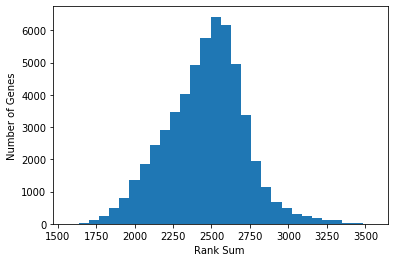

In [15]:
# the rankdata function assign ranks to the data- we want to rank each row (gene)
# the defult method to deal with tie is average 
tRS = np.array(AMI_data.apply(lambda row: sp.rankdata(row), axis = 1))
tRS = pd.DataFrame(np.row_stack(tRS))
tRS.columns = AMI_phenotype.iloc[0,:]
tRS.index = AMI_data.index
tRS = tRS.groupby(tRS.columns,axis=1).sum()

plt.hist(tRS.iloc[:,1],bins=30)
plt.xlabel("Rank Sum ")
plt.ylabel("Number of Genes")
plt.show()

# c. Differential Expression
The purpose is to determine the statistical significance of differential expression (DE) observed for each gene in H vs M.
Evaluate the DE in both one-sided directions for every gene, using both Student t-test and WRS test. 
Report the number of genes overexpressed in M vs H at a p-value better (≤) than 0.05 and separately genes underexpressed in M vs H at a p-value of 0.05. For both directions use both a Student t-test and a WRS test.


In [25]:
#subseting
H,M = AMI_data.groupby(AMI_phenotype.iloc[0,:],axis=1)
H = pd.DataFrame(H[1])
M = pd.DataFrame(M[1])
M.head(2)

Class              M                                                         \
ID_REF    GSM1620832 GSM1620833 GSM1620834 GSM1620835 GSM1620836 GSM1620837   
1007_s_at   5.511752   5.663843   4.562416   5.237784   5.310519   5.249899   
1053_at     7.856591   6.849618   7.956047   7.710327   7.984931   8.708723   

Class                                                  ...             \
ID_REF    GSM1620838 GSM1620839 GSM1620840 GSM1620841  ... GSM1620908   
1007_s_at   5.511501   4.949108   5.151583   5.126908  ...   5.419482   
1053_at     8.087234   7.872137   8.146644   7.904487  ...   7.226348   

Class                                                                        \
ID_REF    GSM1620909 GSM1620910 GSM1620911 GSM1620912 GSM1620913 GSM1620914   
1007_s_at   5.057716   5.996493   5.343133   5.558892   6.472517   5.678816   
1053_at     7.105538   5.354105   8.271500   5.963346   8.261422   6.925753   

Class                                       
ID_REF    GSM1620915 GSM1620916 GSM1620917  
1007_s_at   5.653286   6.013841   5.465334  
1053_at     7.918424   7.442701   9.225221  

[2 rows x 49 columns]

In [32]:
W_stat = []
p_val_WRS = []

for i in range(AMI_data.shape[0]):
    w,p = sp.ranksums(M.iloc[i],H.iloc[i])
    W_stat.append(w)
    p_val_WRS.append(p/2)
stop = timeit.default_timer()
 

WRS_DE = pd.DataFrame(data = {"p_val_WRS":p_val_WRS,"W_stat":W_stat,"HorM":"Non-Sig"},index = AMI_data.index)
WRS_DE['HorM'][(WRS_DE['W_stat']<0) & (WRS_DE['p_val_WRS']<0.05)] = 'H'
WRS_DE['HorM'][(WRS_DE['W_stat']>0) & (WRS_DE['p_val_WRS']<0.05)] = 'M'
print("the obsevatiopn of gene significance partitution for WRS test is:\n",WRS_DE['HorM'].value_counts())


the obsevatiopn of gene significance partitution is: 
 Non-Sig    36133
H           9476
M           9019
Name: HorM, dtype: int64


C:\Users\noamha.WISMAIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\noamha.WISMAIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [33]:
T_stat = []
p_val_ttest = []
for i in range(AMI_data.shape[0]):
    t,p = sp.ttest_ind(M.iloc[i],H.iloc[i])
    T_stat.append(t)
    p_val_ttest.append(p/2)

Ttest_DE = pd.DataFrame(data = {"p_val_ttest":p_val_ttest,"T_stat":T_stat,"HorM":"Non-Sig"},index = AMI_data.index)
Ttest_DE['HorM'][(Ttest_DE['T_stat']<0) & (Ttest_DE['p_val_ttest']<0.05)] = 'H'
Ttest_DE['HorM'][(Ttest_DE['T_stat']>0) & (Ttest_DE['p_val_ttest']<0.05)] = 'M'
print("the obsevatiopn of gene significance partitution for T-test is:\n", Ttest_DE['HorM'].value_counts())


the obsevatiopn of gene significance partitution is: 
 Non-Sig    40094
H           7467
M           7067
Name: HorM, dtype: int64


C:\Users\noamha.WISMAIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\noamha.WISMAIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


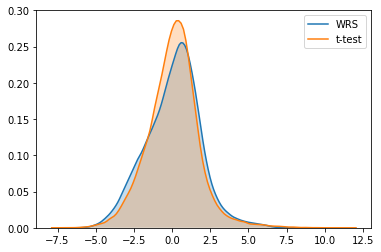

In [34]:
# plot the distribution of the test statistic for beter understanding of the difference
sns.kdeplot(WRS_DE['W_stat'], shade= True, label="WRS")
sns.kdeplot(Ttest_DE['T_stat'], shade= True, label="t-test")


# d. Correlations
Select the 60 most significant genes from each one of the one-sided WRS DE lists you computed in 3c. Generate a set of 120 genes, D, which is the union of the above two sets.
Compute Spearman rho correlations in all pairs within D (120 choose 2 numbers). 

### 1)	What can you report about co-expression of genes in D (co-expression is inferred from the correlation of the expression levels of genes, across a set of samples)? Do we observe any significant co-expression? If so how many pairs, etc.

In [44]:
#Select the 60 most significant genes from each one of the one-sided WRS DE lists
Ttest_DE.loc[Ttest_DE['T_stat'].idxmin()]
M_DE = WRS_DE[WRS_DE["HorM"]=='M'].sort_values("p_val_WRS").index[0:60]
H_DE = WRS_DE[WRS_DE["HorM"]=='H'].sort_values("p_val_WRS").index[0:60]

D = AMI_data.loc[H_DE.union(M_DE)]
rho_D,pval_D = sp.spearmanr(D,axis = 1)
n=(sum(sum(pval_D<0.05))-120)/2
N=(pval_D.shape[0]*pval_D.shape[1]-120)/2
print("there are ", n, " significant correlation pairs (whith no correction) out of ", N, " pairs. \nwe can see that the vast majority of those genes are co-expressed in a meaningfull menar.")

there are  6993.0  significant correlation pairs (whith no correction) out of  7140.0  pairs. 
we can see that the vast majority of those genes are co-expressed in a meaningfull menar.


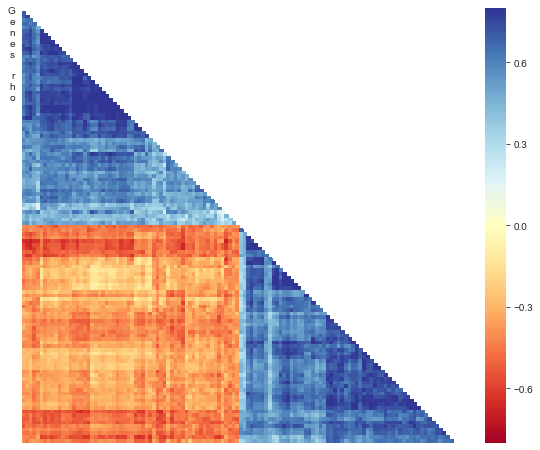

In [53]:
HC_rho_D = sns.clustermap(rho_D,square = True)
mask = np.zeros_like(HC_rho_D.data2d)
mask[np.triu_indices_from(mask)] = True
plt.close()
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(HC_rho_D.data2d, mask=mask, square=True,cmap = "RdYlBu",vmin=-0.8,vmax=0.8)
    ax.set_yticklabels('Genes rho')
    ax.set_xticklabels('')
    plt.show()



### 2)	What would have been advantages and disadvantages of computing co-expression for all genes in the study rather than only for genes in D? 


Taking all genes (54,628) will result in ~(54628^2)/2 correlation tests. If multiple testing correction is not performed (such as in d1) it will result in high number of false positives.
On the other hand, restricting ourselves to only 120 most significantly DE genes, we are potenially loosing  substantial information of other co expression events.
another disadventage is loosing the biological relevance (M vs H) of co expression when computing all possible correlations because we might find co expression events which are not differential to the disease.

### 3)	Perform the above steps on the same set D, but restrict attention only to samples labeled M. What do you see now? Can you explain this?


In [57]:
D_M = D.loc[:,list(AMI_phenotype.iloc[0,:]=='M')]
rho_D_M,pval_D_M = sp.spearmanr(D_M,axis = 1)


D_H = D.loc[:,list(AMI_phenotype.iloc[0,:]=='H')]
rho_D_H,pval_D_H = sp.spearmanr(D_H,axis = 1)
n=(sum(sum(pval_D_H<0.05))-120)/2
N=(pval_D_H.shape[0]*pval_D_H.shape[1]-120)/2

print("there are ", n, " significant correlation pairs (whith no correction) out of ", N, " pairs. \nactually, this low number is not that suprising as we chose the genes to be as different as possible between M and H. \nWithout the latter its resonable that the rho is lower ")

there are  2410.0  significant correlation pairs (whith no correction) out of  7140.0  pairs. 
actually, this low number is not that suprising as we chose the genes to be as different as possible between M and H. 
Without the latter its resonable that the rho is lower 


# e. Plots and Conclusions of the DE and correlation analysis.
### 1)	Construct the DE overabundance plots (blue and green lines as shown in class) for M vs H overexpression (higher expression levels in M) using WRS and t-test using the results you had computed in Section 3c. 
### State, for each comparison, the number of genes, k, at which we observe:
### a)	FDR = 0.1
### b)	FDR = 0.05
### c)	FDR = 0.001
### If these events are not observed at any k, then make that statement.

C:\Users\noamha.WISMAIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


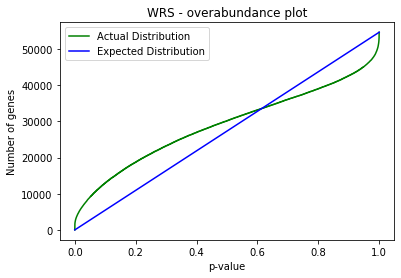

In [58]:
WRS_minus1 = WRS_DE.copy()
WRS_minus1['p_val_WRS'][(WRS_minus1['W_stat']<0)] = 1 - WRS_minus1['p_val_WRS'][(WRS_minus1['W_stat']<0) ] 

pval_WRS_minus1 = np.sort(WRS_minus1['p_val_WRS'])
rank_pval_WRS_minus1 = np.arange(1,len(pval_WRS_minus1)+1)
expected  = pval_WRS_minus1*54628

plt.figure()
plt.plot(pval_WRS_minus1,rank_pval_WRS_minus1, color ='green', label='Actual Distribution')
plt.plot(pval_WRS_minus1,expected, color = 'blue', label='Expected Distribution')
plt.title("WRS - overabundance plot")
plt.xlabel("p-value")
plt.ylabel("Number of genes")
plt.legend()
plt.show()


C:\Users\noamha.WISMAIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


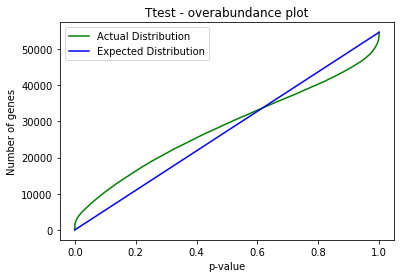

In [59]:
Ttest_DE_minus1 = Ttest_DE.copy()
Ttest_DE_minus1['p_val_ttest'][(Ttest_DE_minus1['T_stat']<0)] = 1 - Ttest_DE_minus1['p_val_ttest'][(Ttest_DE_minus1['T_stat']<0)] 

Ttest_DE_minus1 = np.sort(Ttest_DE_minus1['p_val_ttest'])
rank_Ttest_DE_minus1 = np.arange(1,len(Ttest_DE_minus1)+1)
expected  = Ttest_DE_minus1*54628

plt.figure()
plt.plot(Ttest_DE_minus1,rank_Ttest_DE_minus1, color ='green', label='Actual Distribution')
plt.plot(Ttest_DE_minus1,expected, color = 'blue', label='Expected Distribution')
plt.title("Ttest - overabundance plot")
plt.xlabel("p-value")
plt.ylabel("Number of genes")
plt.legend()
plt.show()

In [61]:
FDR_WRS = ((pval_WRS_minus1)*54628)/(np.arange(1,len(pval_WRS_minus1)+1))
print("number of genes, k, at which we observe for WRS tests:")
print("FDR = 0.1 ->",sum(FDR_WRS<0.1))
print("FDR = 0.05 ->",sum(FDR_WRS<0.05))
print("FDR = 0.001 ->",sum(FDR_WRS<0.001))

FDR_Ttest = ((Ttest_DE_minus1)*54628)/(np.arange(1,len(Ttest_DE_minus1)+1))
print("number of genes, k, at which we observe for T-test tests:")
print("FDR = 0.1 ->",sum(FDR_Ttest<0.1))
print("FDR = 0.05 ->",sum(FDR_Ttest<0.05))
print("FDR = 0.001 ->",sum(FDR_Ttest<0.001))


number of genes, k, at which we observe for WRS tests:
FDR = 0.1 -> 3876
FDR = 0.05 -> 2796
FDR = 0.001 -> 903
number of genes, k, at which we observe for T-test tests:
FDR = 0.1 -> 2775
FDR = 0.05 -> 2104
FDR = 0.001 -> 767


### 2)	What can you say about the difference in results obtained in WRS vs those obtained by Student t-test?

### 3)	Select any 3 differentially expressed genes, from D (which was defined in 3d), and produce a graphical representation of their expression patterns that demonstrates the observed DE.

Text(0.5, 0, 'Random Genes')

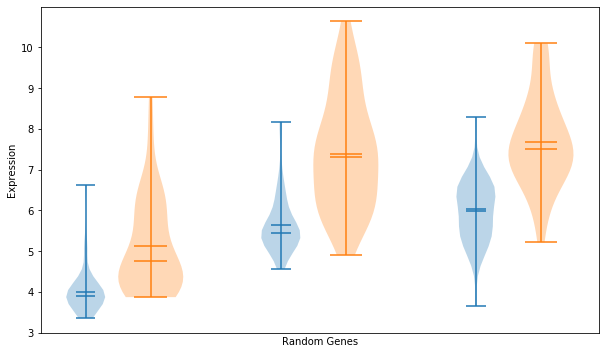

In [84]:
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
Threesome = D.sample(3,replace=False, random_state=123)
fig, ax1 = plt.subplots(figsize=(10, 6), sharey=True)
plt.violinplot(Threesome['H'],[1,2.5,4], points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.violinplot(Threesome['M'],[1.5,3,4.5], points=40, widths=0.5,showmeans=True, showextrema=True, showmedians=True)
plt.xticks([])
plt.ylabel('Expression')
plt.xlabel('Random Genes')


### 4)	Heatmap : Draw a heatmap representation of the expression values of the genes in D (from 3c), across the entire cohort (all samples). Order the genes and the samples to produce the maximal visual effect.

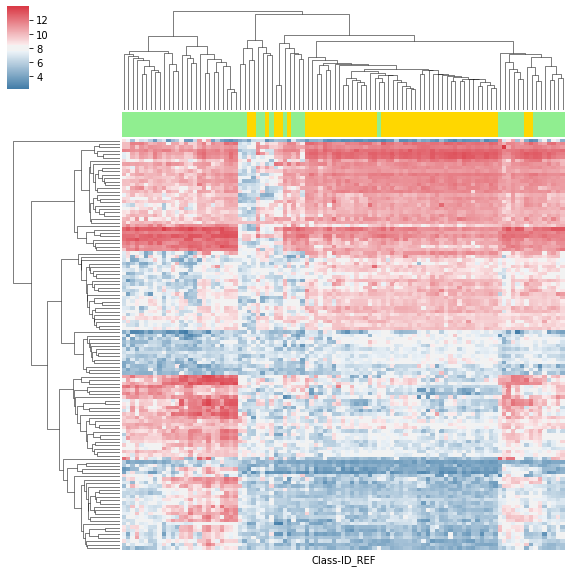

In [95]:
sns.clustermap(D, cmap=sns.diverging_palette(240, 10, sep=20, as_cmap=True), xticklabels=False, yticklabels=False, col_colors = ["lightgreen" if x=="M" else "gold" for x in AMI_phenotype.iloc[0,:]])

# f. Naïve Bayes classifier
### Use the 6 most significant DE genes according to WRS – best 3 positive WRS and best 3 negative WRS. Perform Naïve Bayes classification to predict the classes M vs H. Use the sklearn Naïve Bayes library. Work with 80/20 train test split and report both training and test data performance, as confusion matrices.


In [145]:
top_6_genes_ind = list(M_DE[0:3].append(H_DE[0:3]))
top_6_exp = D.loc[top_6_genes_ind]

X = np.array(top_6_exp.transpose())
Y = np.array([([1] * top_6_exp['H'].shape[1] + ([0] * top_6_exp['M'].shape[1]))]).flatten()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
gnb = GaussianNB()
Y_pred = gnb.fit(X_train, Y_train).predict(X_test)
train_pred = gnb.fit(X_train, Y_train).predict(X_train)

In [159]:
print("confusion matrix of test:\n",confusion_matrix(Y_test, Y_pred))
print("confusion matrix of train:\n",confusion_matrix(Y_train, train_pred))
print('Number of mistakes in train prediction out of a total of ',X_train.shape[0], 'is: ',(Y_train != train_pred).sum())
print('\nNumber of mistakes in test prediction out of a total of ',X_test.shape[0],'is: ', (Y_test != Y_pred).sum())


confusion matrix of test:
 [[ 5  3]
 [ 0 12]]
confusion matrix of train:
 [[26 15]
 [ 5 33]]
Number of mistakes in train prediction out of a total of  79 is:  20

Number of mistakes in test prediction out of a total of  20 is:  3


# g. New GEO dataset analysis
### Download another dataset from GEO (link) and report selected analysis steps. The selected dataset should have at least 80 samples and at least two classes of samples. You can choose to work with non-human data if you like.

* Note: your class presentation should include all elements but focus (and spend most time) on g. Explain your decisions and choices and present conclusions in a broad context whenever possible.
